In [ ]:
#resnet10 3D

In [4]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import keras

from keras.models import Sequential, Model, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input, Add, Dense, Activation, ZeroPadding3D, BatchNormalization, Flatten, Conv3D, AveragePooling3D
from keras.initializers import glorot_uniform
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import Sequence

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

from os.path import join
from random import randint

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

C:\Users\mdavid\Miniconda3\envs\tf_torch_cv2_np_pd\lib\site-packages\tensorflow\python\client\session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [2]:
def convolutional_block(X, f, filters, stage, s=2):   
    conv_name_base = 'conv' + str(stage) + '_conv3d_'
    bn_name_base = 'conv' + str(stage) + '_bn_'

    F1, F2 = filters

    X_shortcut = X

    X = Conv3D(filters=F1, kernel_size=(f, f, f), strides=(s, s, s), padding='same', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '1')(X)
    X = Activation('relu')(X)
    
    X = Conv3D(filters=F2, kernel_size=(f, f, f), strides=(1, 1, 1), padding='same', name=conv_name_base + '2', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(name=bn_name_base + '2')(X)
    
    X_shortcut = Conv3D(filters=F2, kernel_size=(f, f, f), strides=(s, s, s), padding='same', name=conv_name_base + '1shortcut', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(name=bn_name_base + '1shortcut')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    print("X_conv{} : ".format(stage), X.shape)

    return X

def ResNet10_3D(input_shape=(8, 224, 224, 3)):

    X_input = Input(input_shape)
    print("input : ", X_input.shape)
    X = ZeroPadding3D((1, 3, 3))(X_input)
    
    print("zeroPadding : ",X.shape)
    #conv1
    X = Conv3D(64, (3, 7, 7), strides=(1, 2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(name='bn_conv1')(X)
    print("X_conv1 : ", X.shape)
    
    #according to GesRec paper : no MaxPool on Resnet10
    #X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    
    #conv2
    X = convolutional_block(X, f=3, filters=[16, 16], stage=2)

    #conv3
    X = convolutional_block(X, f=3, filters=[32, 32], stage=3)
    
    #conv4
    X = convolutional_block(X, f=3, filters=[64, 64], stage=4)
    
    #conv5
    X = convolutional_block(X, f=3, filters=[128, 128], stage=5)

    #avgPool
    X = AveragePooling3D(padding='same')(X)
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid')(X)
    
    model = Model(inputs=X_input, outputs=X, name='ResNet10')

    return model

model = ResNet10_3D(input_shape=(8, 112, 112, 3))

model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ["accuracy"])
model.summary()
#model.save('3DResnet10.h5')

input :  (None, 8, 112, 112, 3)
zeroPadding :  (None, 10, 118, 118, 3)
X_conv1 :  (None, 8, 56, 56, 64)
X_conv2 :  (None, 4, 28, 28, 16)
X_conv3 :  (None, 2, 14, 14, 32)
X_conv4 :  (None, 1, 7, 7, 64)
X_conv5 :  (None, 1, 4, 4, 128)
Model: "ResNet10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8, 112, 112, 0                                            
__________________________________________________________________________________________________
zero_padding3d (ZeroPadding3D)  (None, 10, 118, 118, 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv3D)                  (None, 8, 56, 56, 64 28288       zero_padding3d[0][0]             
________________________________________________________

In [5]:
class DataGeneratorDetector(Sequence):
    
    def load_sample(self, video, id_begin_frame, id_end_frame, padding):
        sample = []
        
        #load frames
        for frame_id in range(id_begin_frame, id_end_frame + 1):
            img_path = os.path.join(self.dataset_path, 'videos', str(video), "{}.jpg".format(str(frame_id)))
            img = cv2.imread(img_path)
            sample.append(img)
        
        #add padding :copy last frame
        for frame_id in range(padding):
            sample.append(sample[-1])
            
        return np.array(sample)
    
    def augment_sample(self, sample):
        pack = []
        seed = randint(0, 100000)
        #apply the same augmentation to images from the same sample
        for i in range(len(sample)):
            image = self.augmenter.flow(np.array([sample[i]]), seed=seed).next()[0].astype('uint8')
            pack.append(image)
            
        return pack

    def resize_sample(self, video_data, size):
        return np.array([cv2.resize(frame, dsize=size, interpolation=cv2.INTER_CUBIC) for frame in video_data])
        
    def __init__(self, dataset_path, annotation_path, batch_size, augment):
        self.batch_size = batch_size
        self.dataset_path = dataset_path
        self.files = pd.read_csv(annotation_path)
        self.augmenter = ImageDataGenerator(width_shift_range=[-20,20], height_shift_range=[-15,15], rotation_range=15, brightness_range=[0.2,1.2], zoom_range=[0.8,1.2])
        self.augment = augment

    def __len__(self):
        return len(self.files) // self.batch_size

    def __getitem__(self, index):
    
        begin = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_data = self.files[begin:end]
        
        X, y = self.__get_data(batch_data)
        return X, y
    
    def __get_data(self, batch_data):
        X = []
        y = []
        
        for i, row in batch_data.iterrows():
            sample = self.load_sample(row['video_id'], row['begin'], row['end'], row['padding'])
           
            if self.augment:
                sample = self.augment_sample(sample)
            
            X.append(sample)
            y.append(row['is_gesture'])
       
        X = np.array(X)
        y = np.array(y)
        
        return X, y

In [6]:
dataset_path = r'C:\Users\mdavid\Desktop\LSF10'
annotation_train = join(dataset_path, 'annotations_detector_train.csv')
annotation_validation = join(dataset_path, 'annotations_detector_val.csv')

#init generators
train_generator = DataGeneratorDetector(dataset_path=dataset_path, annotation_path=annotation_train, batch_size=32, augment=True)
val_generator = DataGeneratorDetector(dataset_path=dataset_path, annotation_path=annotation_validation, batch_size=32, augment=False)

With data augmentation : 


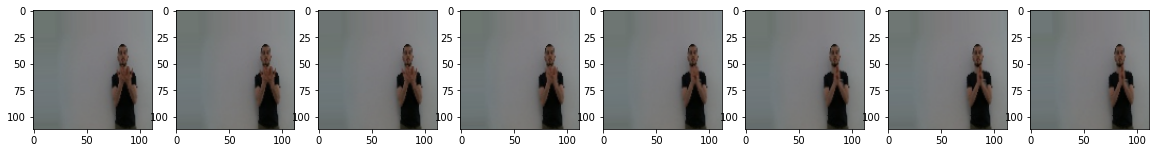

Without data augmentation : 


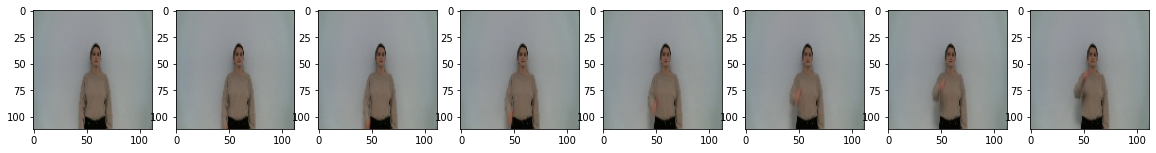

In [13]:
#display sample to preview dataaugmentation

sample_train = train_generator.__getitem__(0)[0][2]
sample_val = val_generator.__getitem__(0)[0][2]

def print_sample(sample):
    
    plt.figure(figsize=(20,10))
    for i in range(len(sample)):
        plt.subplot(1, 8, i+1)
        plt.imshow(sample[i,:,:,::-1])
    plt.show()

print('With data augmentation : ')
print_sample(sample_train)
print('Without data augmentation : ')
print_sample(sample_val)

In [33]:
#train, takes around 3 hours on RTX 2080

#check if GPU is active
if tf.test.gpu_device_name(): 
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

#save checkpoint when best val accuracy is beaten
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="../models/LSF10_detector.h5",
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

#early stopping if no improvements on loss during 20 consecutive epochs
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

    
H = model.fit(train_generator, validation_data=val_generator, epochs=100, verbose=1, callbacks=[checkpoint, es])

Default GPU Device: /device:GPU:0
Epoch 1/100
201/201 [==============================] - 166s 825ms/step - loss: 0.5511 - accuracy: 0.7433 - val_loss: 0.3153 - val_accuracy: 0.8778

Epoch 00001: val_accuracy improved from -inf to 0.87784, saving model to ../models\LSF10_detector.h5
Epoch 2/100
201/201 [==============================] - 169s 840ms/step - loss: 0.3603 - accuracy: 0.8434 - val_loss: 0.3121 - val_accuracy: 0.8693

Epoch 00002: val_accuracy did not improve from 0.87784
Epoch 3/100
201/201 [==============================] - 158s 785ms/step - loss: 0.2933 - accuracy: 0.8725 - val_loss: 0.3703 - val_accuracy: 0.8679

Epoch 00003: val_accuracy did not improve from 0.87784
Epoch 4/100
201/201 [==============================] - 169s 838ms/step - loss: 0.2646 - accuracy: 0.8854 - val_loss: 0.2468 - val_accuracy: 0.9119

Epoch 00004: val_accuracy improved from 0.87784 to 0.91193, saving model to ../models\LSF10_detector.h5
Epoch 5/100
201/201 [==============================] - 200s

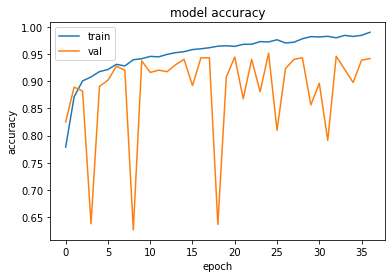

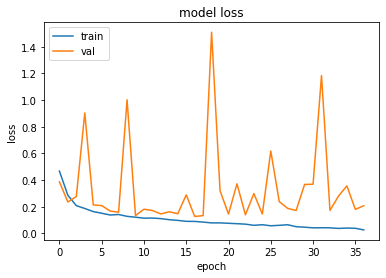

In [6]:
#display training curves

#accuracy
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [7]:
#check if model was correctly saved

model = keras.models.load_model('../models/LSF10_detector.h5')
score = model.evaluate(val_generator, verbose=1)

print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

22/22 [==============================] - 2s 75ms/step - loss: 0.1454 - accuracy: 0.9517
Test loss: 0.14542530477046967 / Test accuracy: 0.9517045617103577


(32, 8, 112, 112, 3)
ground trh :  gesture
prediction :  gesture


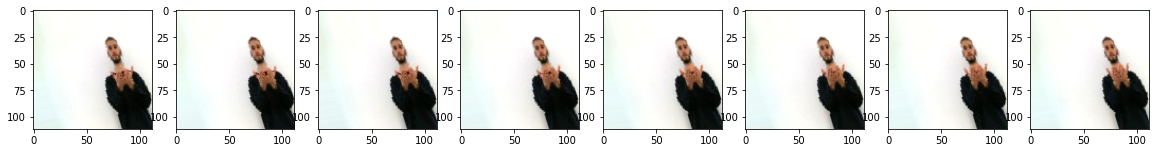

ground trh :  gesture
prediction :  gesture


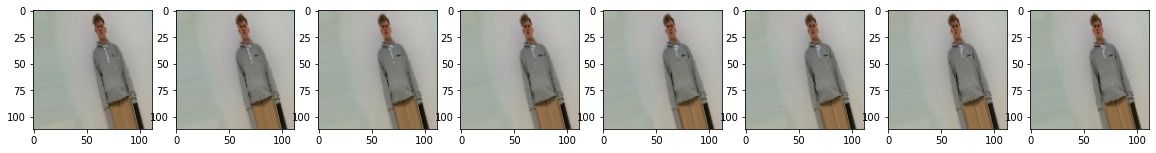

ground trh :  gesture
prediction :  gesture


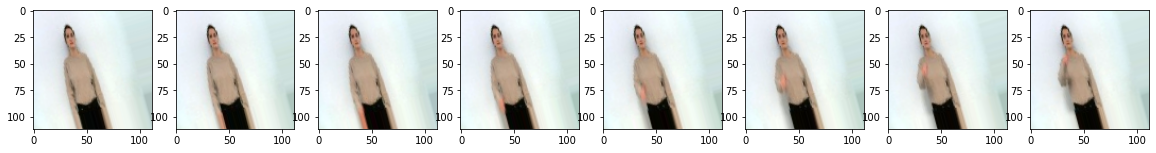

ground trh :  no gesture
prediction :  gesture


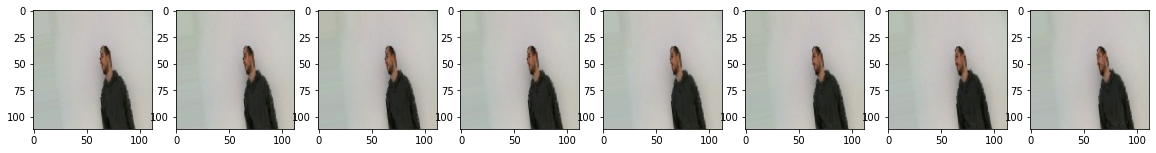

ground trh :  no gesture
prediction :  gesture


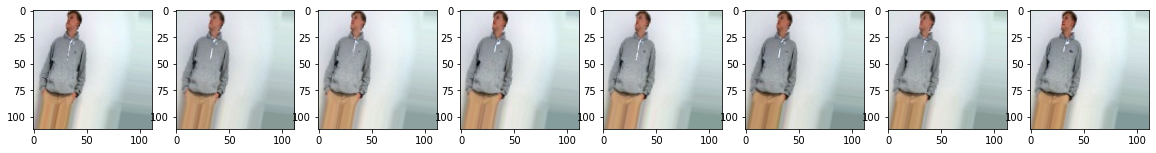

ground trh :  gesture
prediction :  gesture


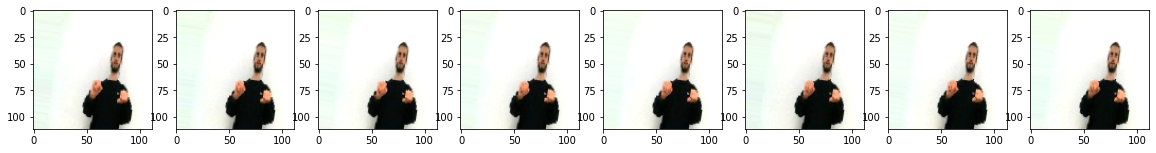

ground trh :  no gesture
prediction :  no gesture


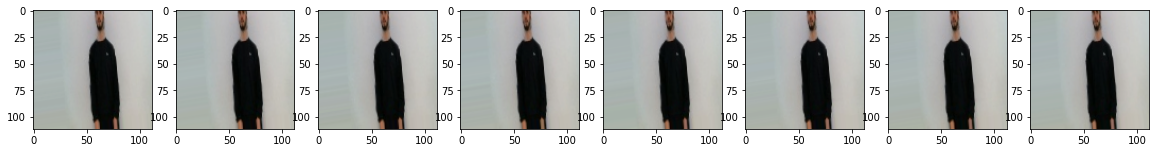

ground trh :  gesture
prediction :  gesture


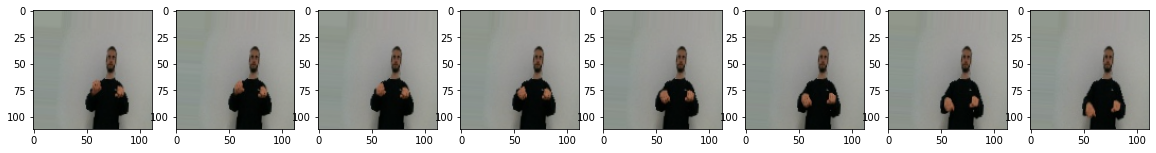

ground trh :  no gesture
prediction :  gesture


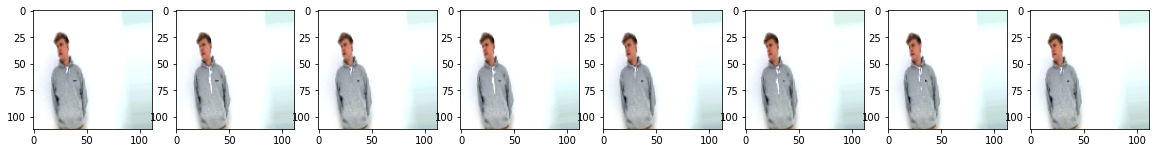

ground trh :  gesture
prediction :  gesture


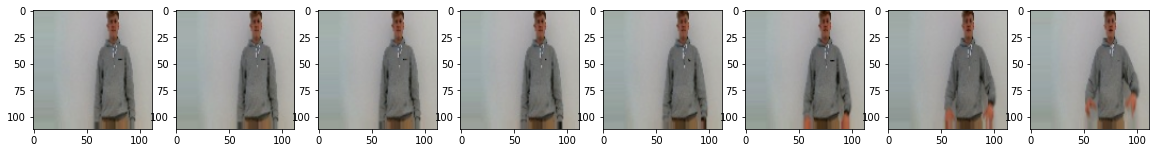

ground trh :  no gesture
prediction :  no gesture


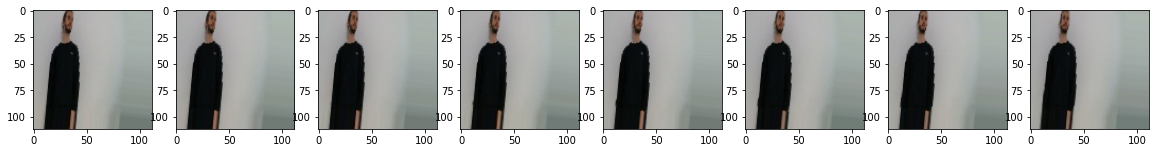

ground trh :  gesture
prediction :  gesture


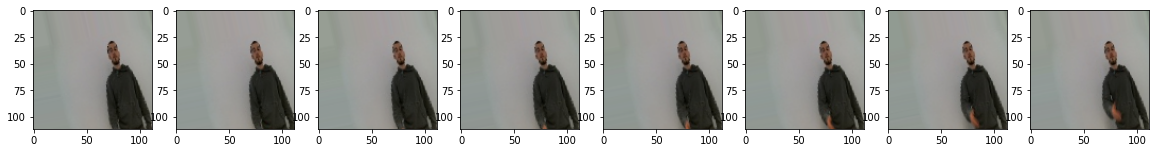

ground trh :  no gesture
prediction :  no gesture


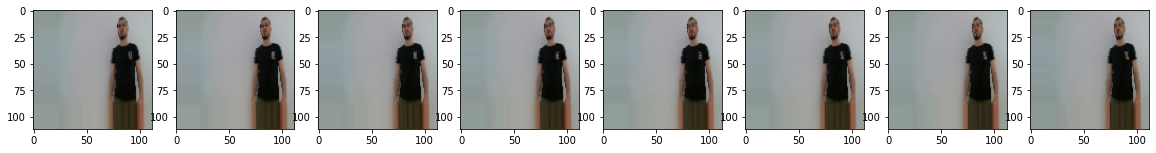

ground trh :  no gesture
prediction :  no gesture


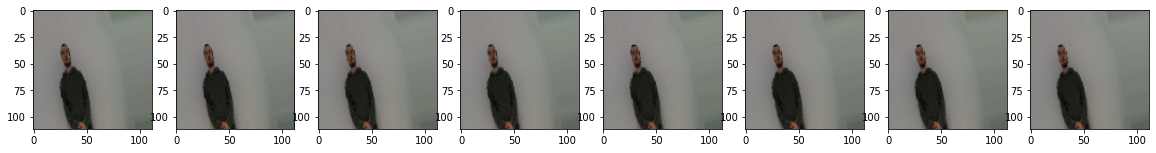

ground trh :  no gesture
prediction :  gesture


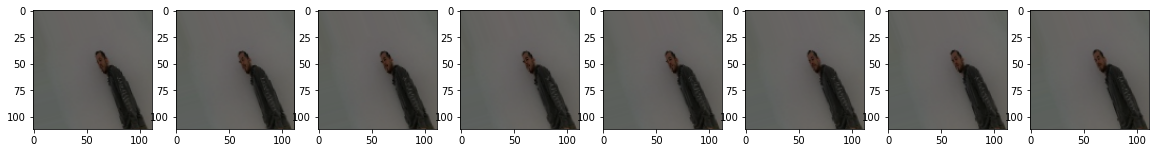

ground trh :  gesture
prediction :  gesture


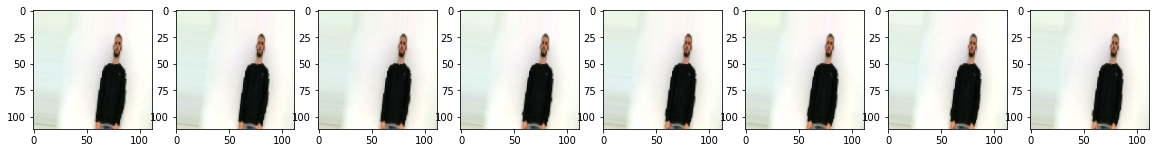

ground trh :  gesture
prediction :  gesture


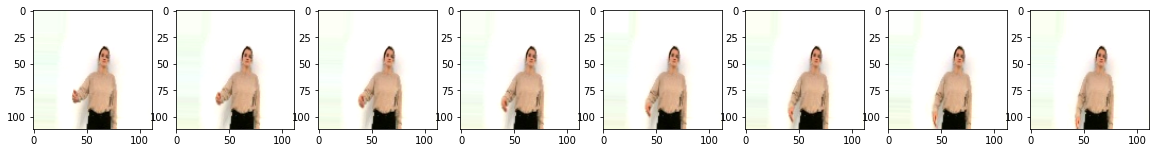

ground trh :  gesture
prediction :  gesture


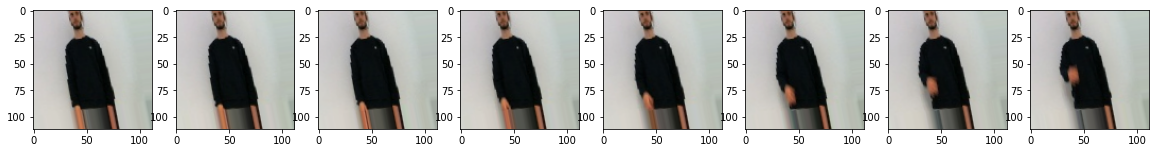

ground trh :  gesture
prediction :  gesture


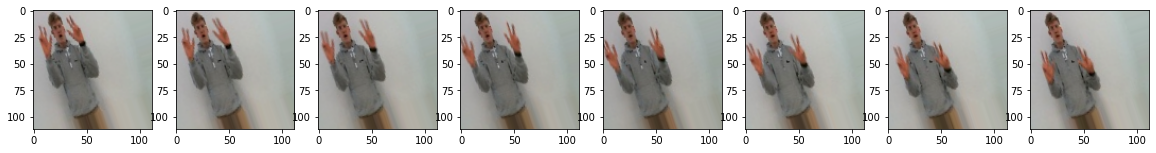

ground trh :  gesture
prediction :  gesture


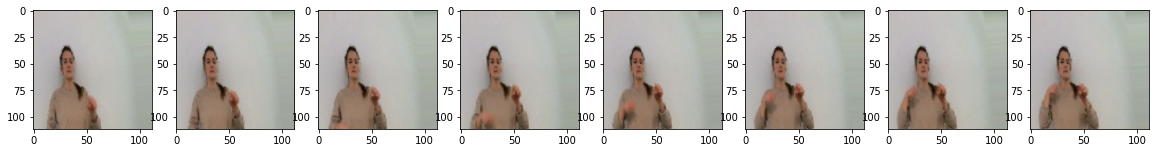

ground trh :  no gesture
prediction :  gesture


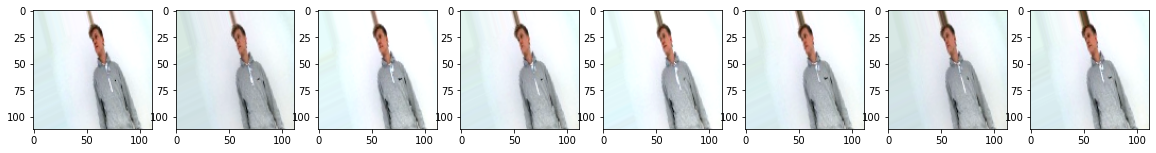

ground trh :  gesture
prediction :  gesture


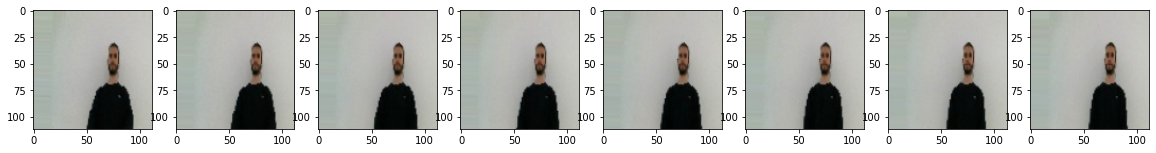

ground trh :  gesture
prediction :  no gesture


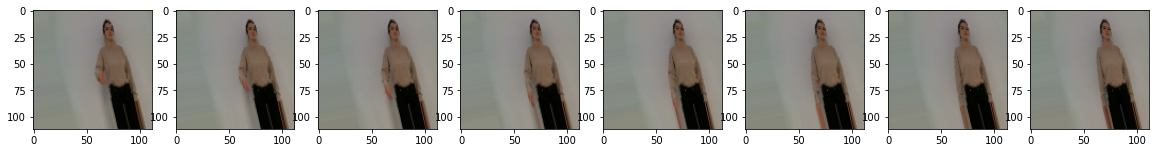

ground trh :  gesture
prediction :  gesture


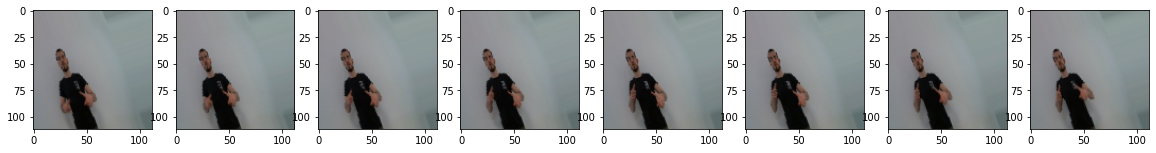

ground trh :  no gesture
prediction :  gesture


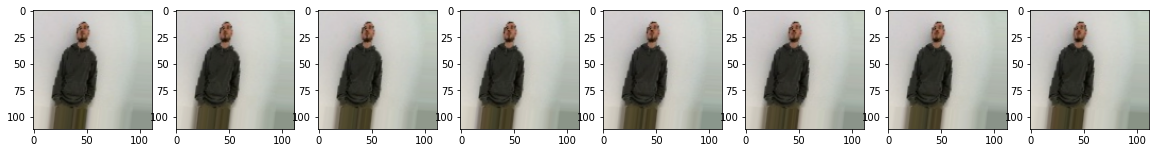

ground trh :  no gesture
prediction :  gesture


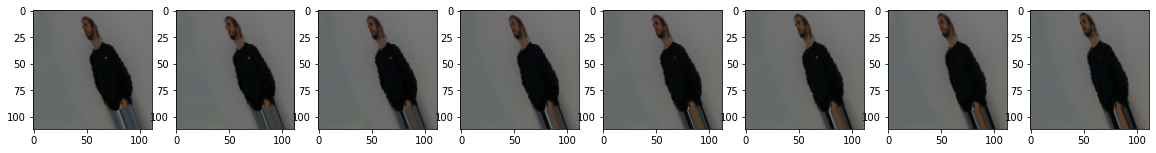

ground trh :  no gesture
prediction :  gesture


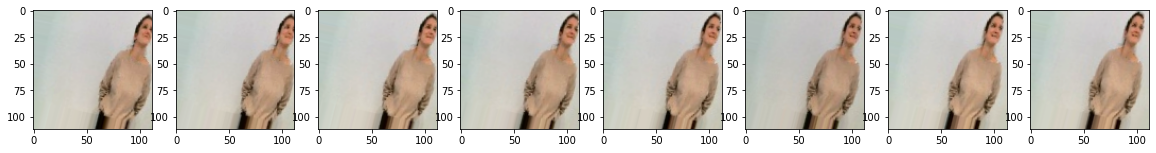

ground trh :  no gesture
prediction :  gesture


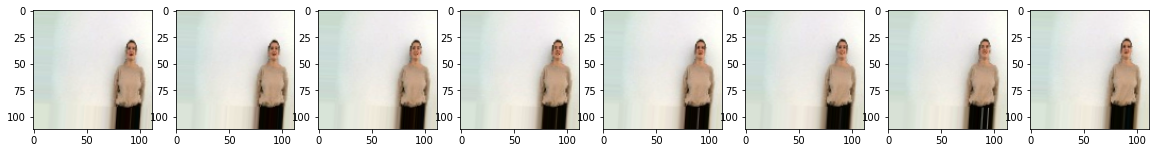

ground trh :  no gesture
prediction :  gesture


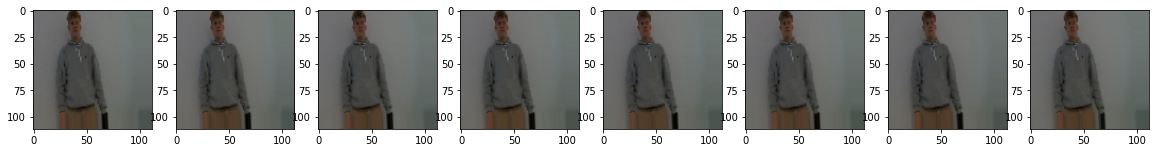

ground trh :  no gesture
prediction :  gesture


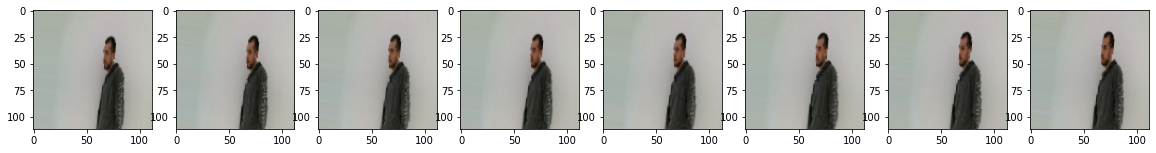

ground trh :  gesture
prediction :  no gesture


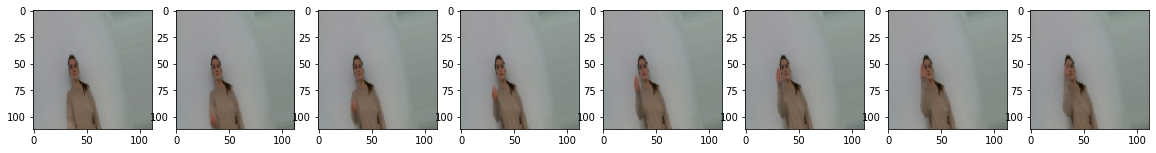

ground trh :  no gesture
prediction :  no gesture


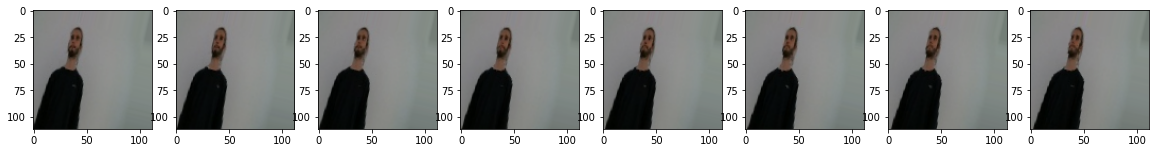

In [29]:
model = keras.models.load_model('../models/LSF10_detector.h5')

X, y = val_generator.__getitem__(0)

labels = ['no gesture', 'gesture']

pred = model.predict(X)

for i, sample in enumerate(X[:10]):
    plt.figure(figsize=(20,10))
    print('ground trh : ', labels[y[i]])
    print('prediction : ', labels[1 if pred[i] > 0.5 else 0])
    print_sample(sample)
    plt.show()

In [1]:
#test on full video 

'''
model = keras.models.load_model('../models/LSF10_detector.h5')

imgs = os.listdir(join('../sandbox/phrases_img', '0'))

labels = ['no gesture', 'gesture']

pack = []
for index in range(len(imgs)):
    img_path = join('../sandbox/phrases_img', '0', '{}.jpg'.format(index))
    pack.append(cv2.resize(cv2.imread(img_path), dsize=(112,112), interpolation=cv2.INTER_CUBIC))
    
    if len(pack) == 8:
        pred = model.predict(np.array([pack])) > 0.5
        #print('ground trh : ', labels[y[i]])
        print('prediction : ', labels[1 if pred else 0])
        plt.figure(figsize=(20,10))
        for j, image in enumerate(pack):
            plt.subplot(1, 8, + j + 1)
            plt.imshow(image[:,:,::-1])
        pack = []
    
    
    plt.show()
'''

"\nmodel = keras.models.load_model('../models/LSF10_detector.h5')\n\nimgs = os.listdir(join('../sandbox/phrases_img', '0'))\n\nlabels = ['no gesture', 'gesture']\n\npack = []\nfor index in range(len(imgs)):\n    img_path = join('../sandbox/phrases_img', '0', '{}.jpg'.format(index))\n    pack.append(cv2.resize(cv2.imread(img_path), dsize=(112,112), interpolation=cv2.INTER_CUBIC))\n    \n    if len(pack) == 8:\n        pred = model.predict(np.array([pack])) > 0.5\n        #print('ground trh : ', labels[y[i]])\n        print('prediction : ', labels[1 if pred else 0])\n        plt.figure(figsize=(20,10))\n        for j, image in enumerate(pack):\n            plt.subplot(1, 8, + j + 1)\n            plt.imshow(image[:,:,::-1])\n        pack = []\n    \n    \n    plt.show()\n"